Visualizing convnet activations

In [ ]:
from itertools import product
import math
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()


model = VGG16(weights='imagenet', include_top=False)

# run model.summary() to get the names of layers

def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  x += 0.5
  x = np.clip(x, 0, 1)

  return x

def generate_pattern(layer_name, filter_index, size=150, steps=40):
  layer_output = model.get_layer(layer_name).output

  loss = K.mean(layer_output[:, :, :, filter_index])

  grads = K.gradients(loss, model.input)[0]

  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

  iterate = K.function([model.input], [loss, grads])

  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128

  alpha = 1

  # step in direction of increasing activation
  for i in range(steps):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * alpha

  img = input_img_data[0]
  return deprocess_image(img)


In [ ]:
def display_layers_activation(layer_name, max_units=0, steps=40):
  layer = model.get_layer(layer_name)
  units = np.shape(model.get_layer(layer_name).output)[-1]
  if max_units != 0:
    units = min(units, max_units)
  cols = 8
  rows = math.ceil(units/cols)
  size = 64
  margin = 3
  results = np.zeros(((rows) * size + (rows-1) * margin, cols * size + (cols-1) * margin, 3))
  for k in range(units):
    print(f'Processing unit {k}/{units}')
    i = k % cols
    j = math.floor(k / cols)
    filter_img = generate_pattern(layer_name, k, size=size, steps=steps)
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[vertical_start: vertical_end,
            horizontal_start: horizontal_end, :] = filter_img

  plt.figure(figsize=(20, 20))
  plt.title('First ' + str(units) + ' units of ' + layer_name)
  plt.imshow(results)

Processing unit 0/16
Processing unit 1/16
Processing unit 2/16
Processing unit 3/16
Processing unit 4/16
Processing unit 5/16
Processing unit 6/16
Processing unit 7/16
Processing unit 8/16
Processing unit 9/16
Processing unit 10/16
Processing unit 11/16
Processing unit 12/16
Processing unit 13/16
Processing unit 14/16
Processing unit 15/16


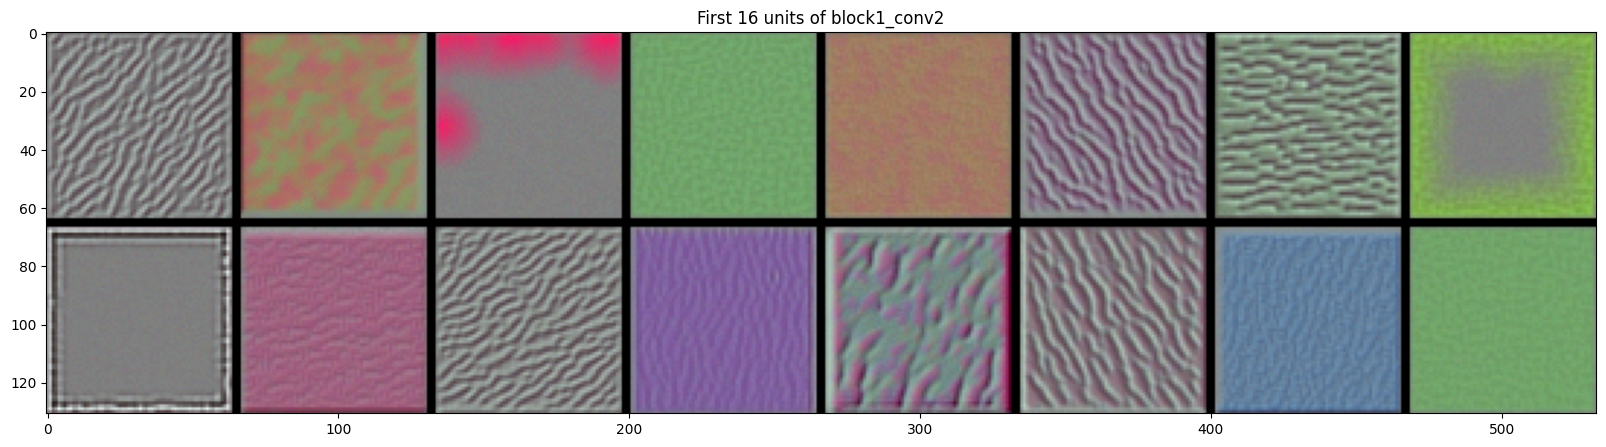

In [ ]:
# replace with desired layer
name = 'block1_conv2'
display_layers_activation(name, steps=60, max_units=16)